# Comparação dos valores medidos e simulados de Ks

In [1]:
import os
import json
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import Infiltrometro, ALL_FUNCTIONS, nse, points_distance

from tqdm import tqdm
from xgboost import XGBRegressor
from shapely.geometry import Point
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import QuantileTransformer

In [2]:
run_ml = True
run_math = True

all_functions = {
    "WMssc": ALL_FUNCTIONS["WMssc"],
    "COSBY": ALL_FUNCTIONS["COSBY"],
    "ROssc": ALL_FUNCTIONS["ROssc"],
    "JULIA": ALL_FUNCTIONS["JULIA"],
    "Puckett": ALL_FUNCTIONS["Puckett"],
    "DanePuckett": ALL_FUNCTIONS["DanePuckett"],
    "Saxton":ALL_FUNCTIONS["Saxton"],
}

In [3]:
infil = pd.read_excel(r"D:\Mestrado\Trabalho Final\Dados\Levantamento em Campo\Compiled.xlsx", sheet_name="Infiltracao")
infil = Infiltrometro(infil)

[ True  True  True  True  True  True  True  True  True False False False
 False False False False False False False False False]


d:\Mestrado\Trabalho Final\Codigos\utils\infiltracao\infiltrometro.py:156: OptimizeWarning: Covariance of the parameters could not be estimated
  (c1, c2), covariance = curve_fit(self._equation_infiltration, t, I)


In [4]:
# K  = infil.K()  # Este valor de K é o K para -2cm de poropressão.
df_Ks:pd.DataFrame = infil.Ks() # Ks é a condutividade Hidráulica Saturada.

len(df_Ks)

Cálculos utilizando C1


84

In [5]:
alfa = df_Ks["alfa"].values
n = df_Ks["n"].values
K = df_Ks["K"].values
Ks:np.ndarray = df_Ks["Ks"].values

In [6]:
def quantile_mapping(sim, obs):
    """Aplica Quantile Mapping (QM) de simulado -> observado"""
    # Ajusta distribuições separadas
    qm_sim = QuantileTransformer(output_distribution="uniform", n_quantiles=min(100, sim.size))
    qm_obs = QuantileTransformer(output_distribution="uniform", n_quantiles=min(100, obs.size))
    
    # Treina cada um na sua série
    qm_sim.fit(sim.reshape(-1, 1))
    qm_obs.fit(obs.reshape(-1, 1))
    
    # Leva simulado para espaço uniforme
    u = qm_sim.transform(sim.reshape(-1, 1))
    
    # Reprojeta no espaço do observado
    sim_corr = qm_obs.inverse_transform(u)
    return sim_corr.flatten()

In [7]:
# Cálculo da distância entre os pontos

# Método 1
initial_point=infil.infiltrations[infil.infiltrations["Ponto"] == "P21"].index.values[0]
df_Ks["distancia_media"] = points_distance(infil.infiltrations, initial_point)

# Método 2
# points = infil.infiltrations.apply(lambda row: Point(row["Lon"], row["Lat"]), axis=1).values
# distances = np.zeros((len(points), len(points)))
# for i in range(len(points)):
#     for j in range(len(points)):
#         distances[i, j] = points[i].distance(points[j])

# # Distancia média entre pontos
# mask = ~np.eye(distances.shape[0], dtype=bool)
# sem_diag = distances[mask].reshape(distances.shape[0], -1)
# medias = sem_diag.mean(axis=1)
# df_Ks["distancia_media"] = medias

df_Ks = df_Ks.sort_values(by="distancia_media", ascending=False)
df_Ks

,Ponto,Ks,K,Kr,θr,θs,n,alfa,Se,l,distancia_media
37,P84,0.035175,0.004594,0.130601,0.117554,0.430325,1.31,0.019,0.996765,0.5,84
26,P63,0.072916,0.009062,0.124284,0.099473,0.395562,1.48,0.059,0.986652,0.5,83
38,P87,0.117166,0.014562,0.124284,0.091702,0.385133,1.48,0.059,0.986652,0.5,82
53,P115,0.009116,0.001133,0.124284,0.090167,0.387950,1.48,0.059,0.986652,0.5,81
44,P97,0.032571,0.004048,0.124284,0.102963,0.396321,1.48,0.059,0.986652,0.5,80
...,...,...,...,...,...,...,...,...,...,...,...
1,P04,0.278450,0.009209,0.033072,0.069378,0.380130,1.89,0.075,0.987206,0.5,5
50,P106,0.138851,0.004592,0.033072,0.078173,0.380183,1.89,0.075,0.987206,0.5,4
28,P69-A,0.109091,0.013558,0.124284,0.095406,0.369795,1.48,0.059,0.986652,0.5,3
80,P156,0.904869,0.046819,0.051741,0.093184,0.414113,1.56,0.036,0.994143,0.5,2


In [8]:
# Seed para permitir reprodutibilidade dos valores pseudo-aleatórios
seed = 42

# Definir uma seed para reprodutibilidade
rng = np.random.default_rng(seed)

In [20]:
KSS:dict[str, dict[str, np.ndarray]] = {}

N_simulacoes = 50_000

pontos_CV = df_Ks["Ponto"].values

sand = infil.infiltrations["Sand"].values
silt = infil.infiltrations["Silt"].values
clay = infil.infiltrations["Clay"].values

y = np.log10(Ks.astype(np.float64))
idxs = np.arange(len(Ks))

for key, value in all_functions.items():
    KSS[key] = {}

    # Local para salvar os resultados do tipo
    os.makedirs(f"simulacoes/{key}", exist_ok=True)

    # Dados sem a correção de viés
    kss:np.ndarray = np.log10(value(sand, silt, clay))
    KSS[key][key] = kss

    # Aplicando as correções de viés
    KSS[key]["CVS"] = {}
    for i in range(1, len(Ks)+1):
        KSS[key]["CVS"][f"CV_{i}"] = []

        comb = math.comb(len(sand), i)

        if comb > N_simulacoes:
            comb = N_simulacoes

        idxs_foi = set()
        for sim in tqdm(range(comb), desc=f"Simulando: {i}", total=comb):
            idx_choice = rng.choice(idxs, size=i, replace=False)
            while tuple(sorted(idx_choice)) in idxs_foi:
                idx_choice = rng.choice(idxs, size=i, replace=False)
            idxs_foi.add(tuple(sorted(idx_choice)))

            values = df_Ks.loc[idx_choice]

            obs = np.log10(values["Ks"].values)
            kss_cv = quantile_mapping(kss, obs)

            dados = {
                "N_SIM": sim,
                "KSS":kss_cv,
                "NSE":nse(kss_cv, y, y.mean()),
                "RMSE":root_mean_squared_error(y, kss_cv)
            }
            KSS[key]["CVS"][f"CV_{i}"].append(dados)

        df = pd.DataFrame(KSS[key]["CVS"][f"CV_{i}"])
        
        df["NSE_MAX"]    = df["NSE"].max()
        df["NSE_MIN"]    = df["NSE"].min()
        df["NSE_MEAN"]   = df["NSE"].mean()
        df["NSE_MEDIAN"] = df["NSE"].median()
        
        df["RMSE_MAX"]    = df["RMSE"].max()
        df["RMSE_MIN"]    = df["RMSE"].min()
        df["RMSE_MEAN"]   = df["RMSE"].mean()
        df["RMSE_MEDIAN"] = df["RMSE"].median()
        
        df.pop("KSS")
        df.to_excel(f"simulacoes//{key}/CV_{i}.xlsx", index=False)

        KSS[key]["CVS"][f"CV_{i}"] = df

KSS.keys()

Simulando: 84: 100%|██████████| 1/1 [00:00<00:00, 319.79it/s]


A função proposta por Saxton não funciona corretamente


Simulando: 84: 100%|██████████| 1/1 [00:00<?, ?it/s]


dict_keys(['WMssc', 'COSBY', 'ROssc', 'JULIA', 'Puckett', 'DanePuckett', 'Saxton'])

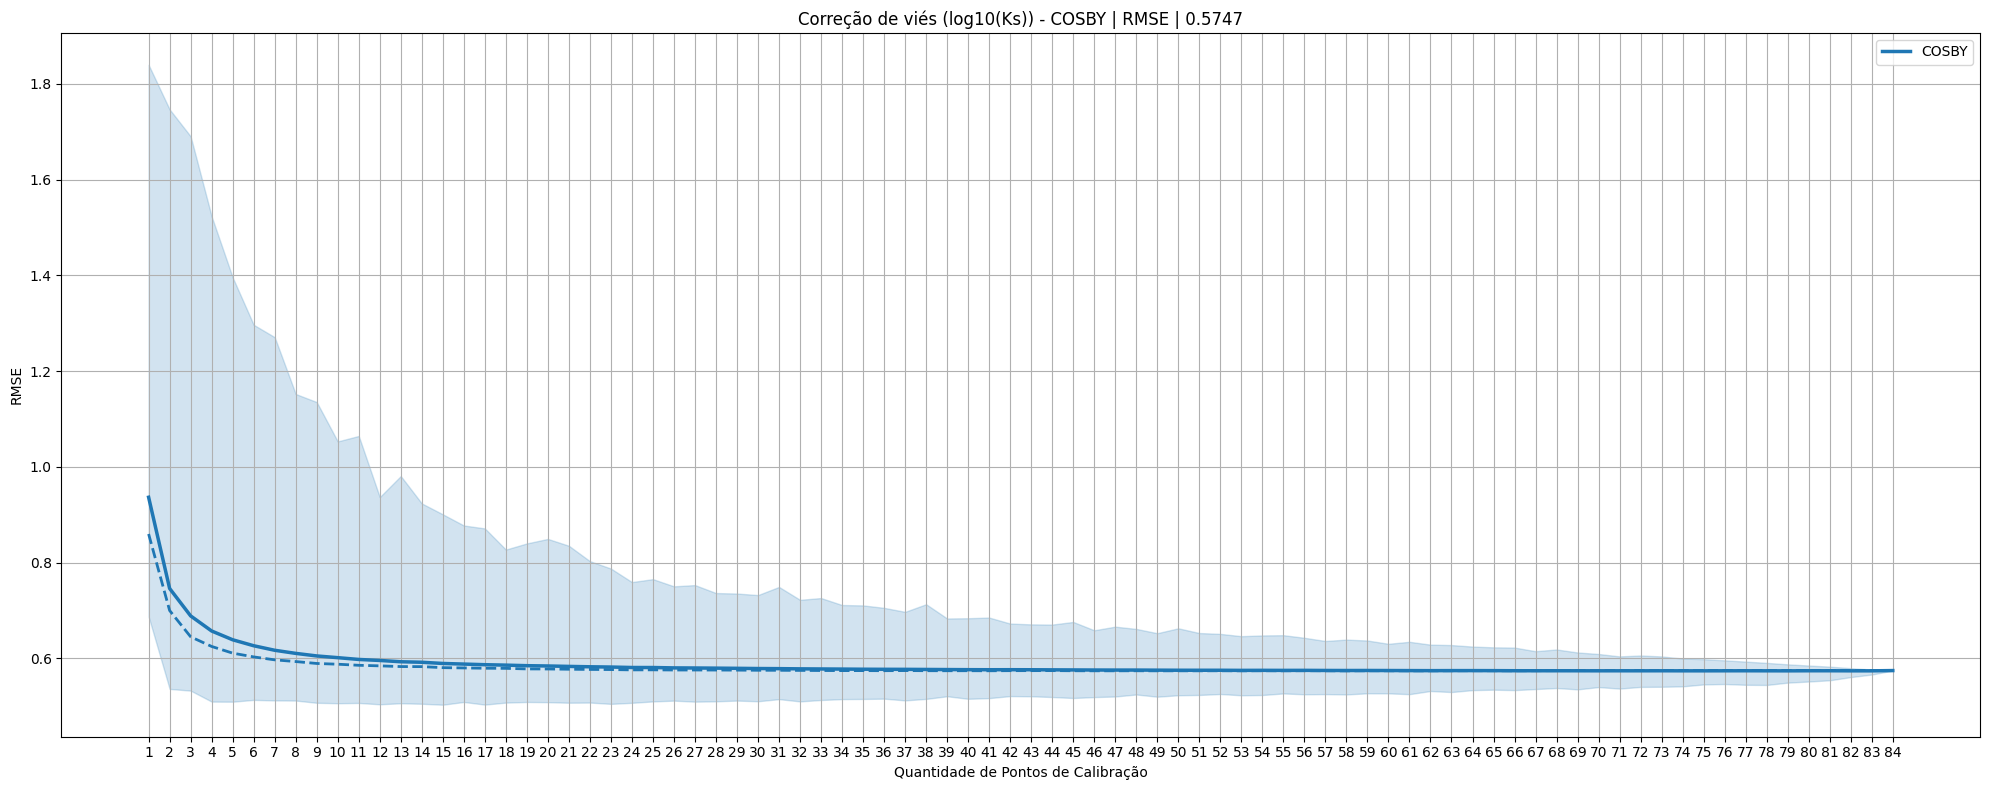

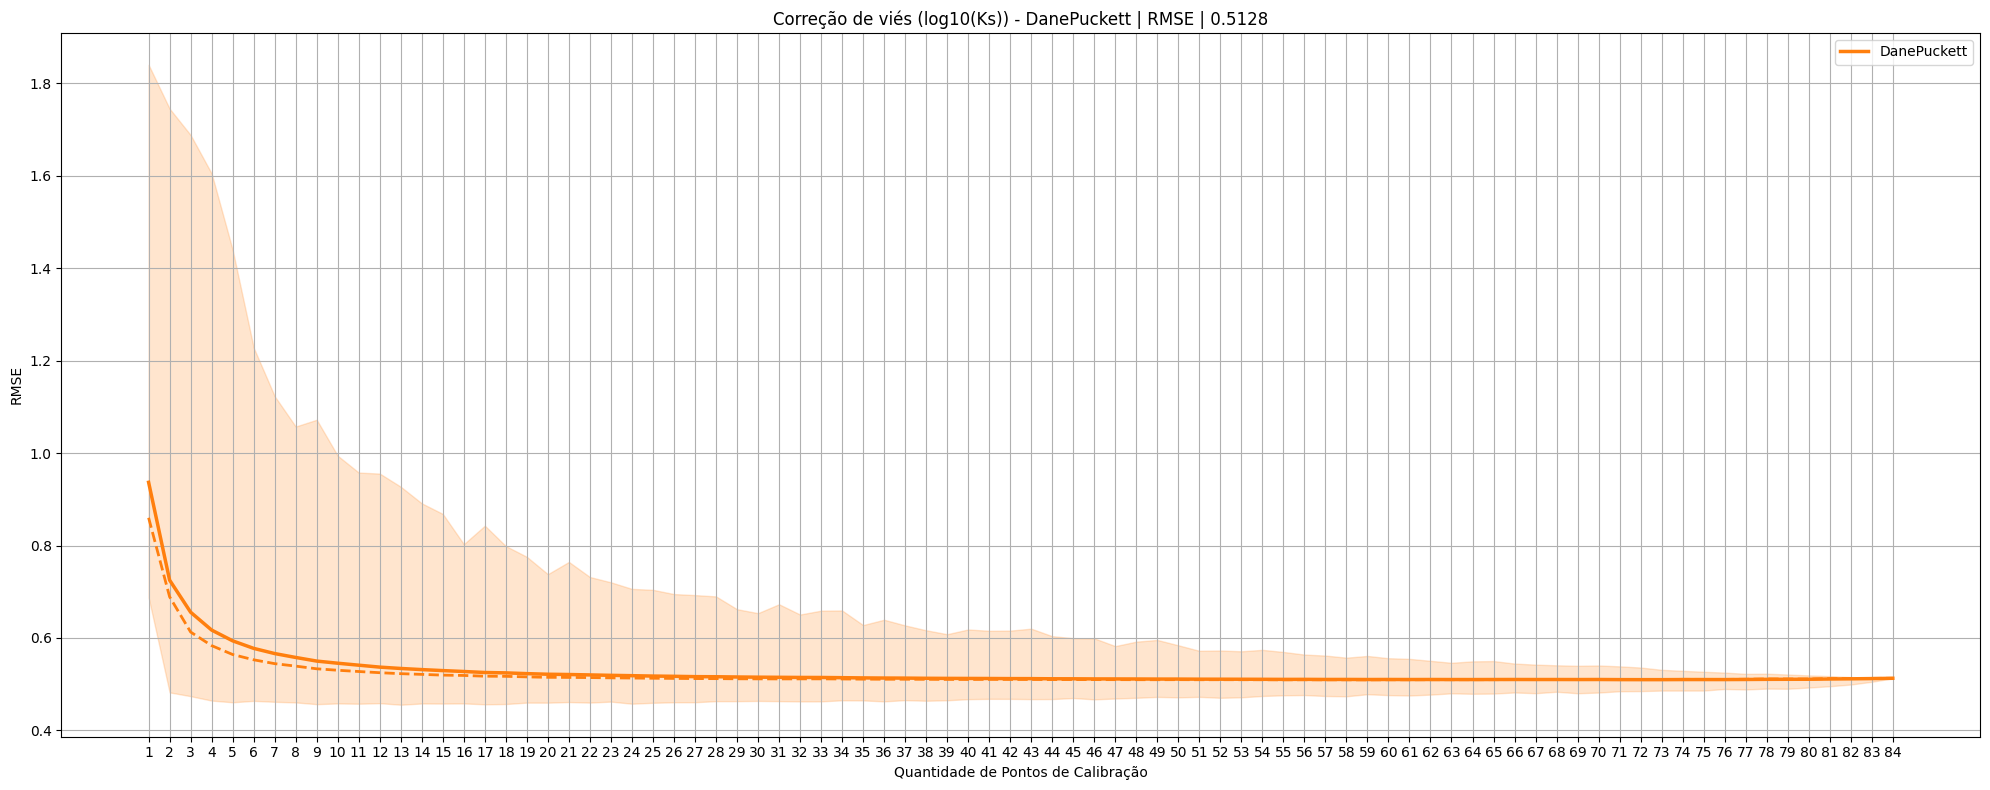

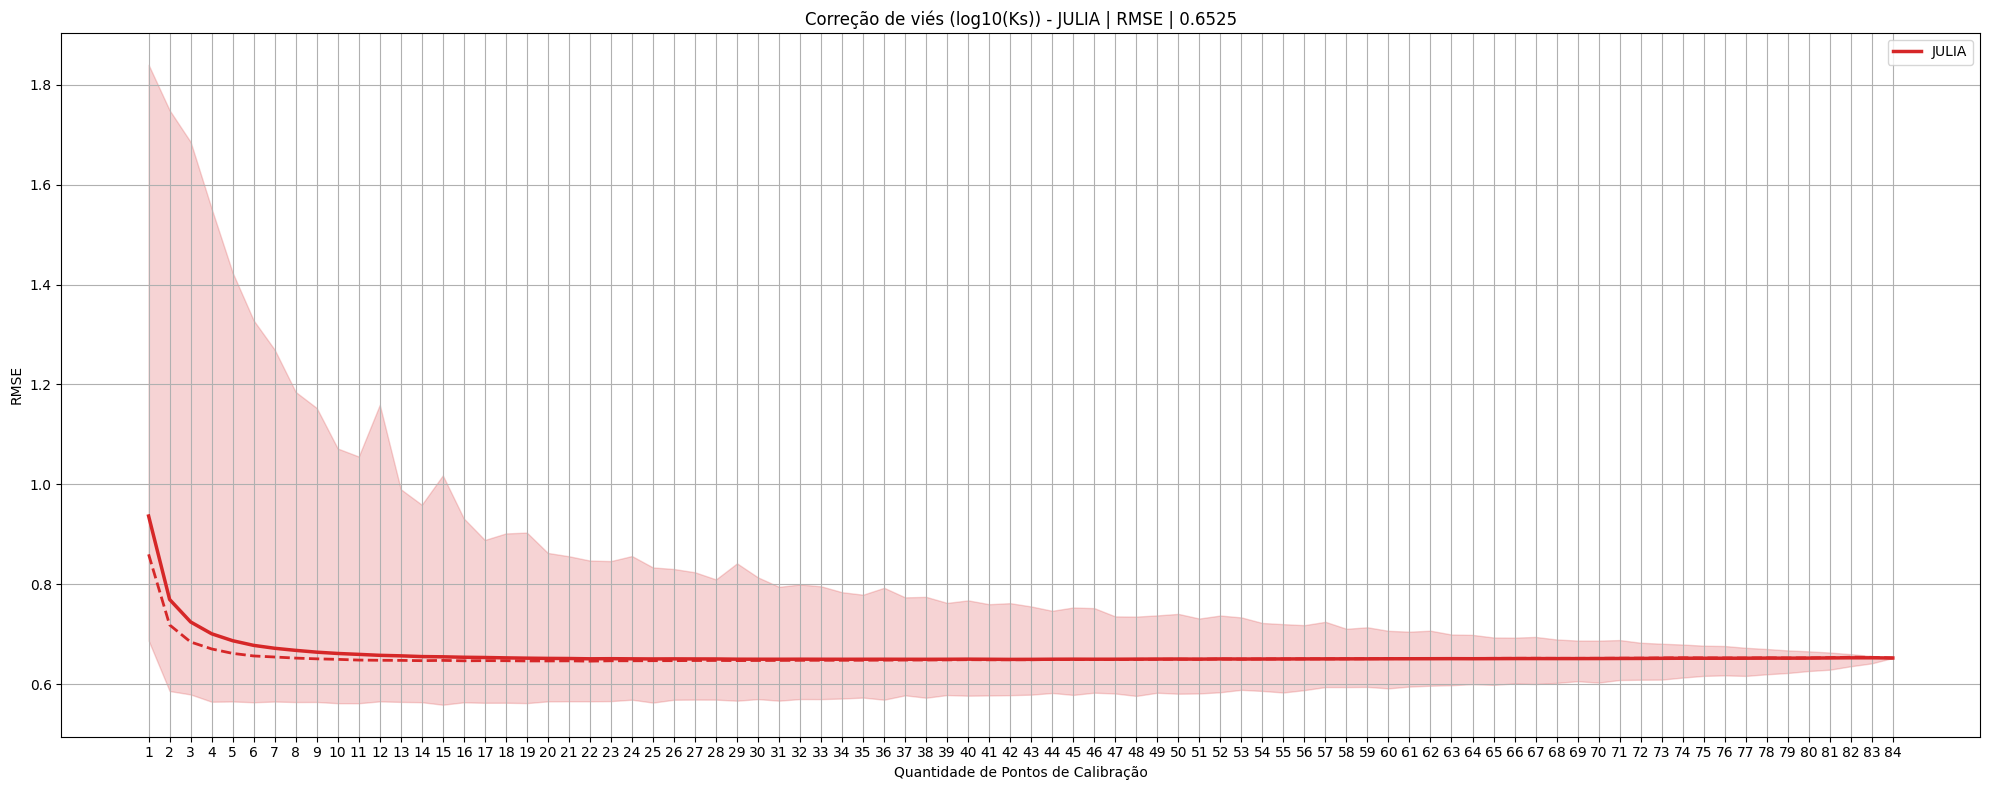

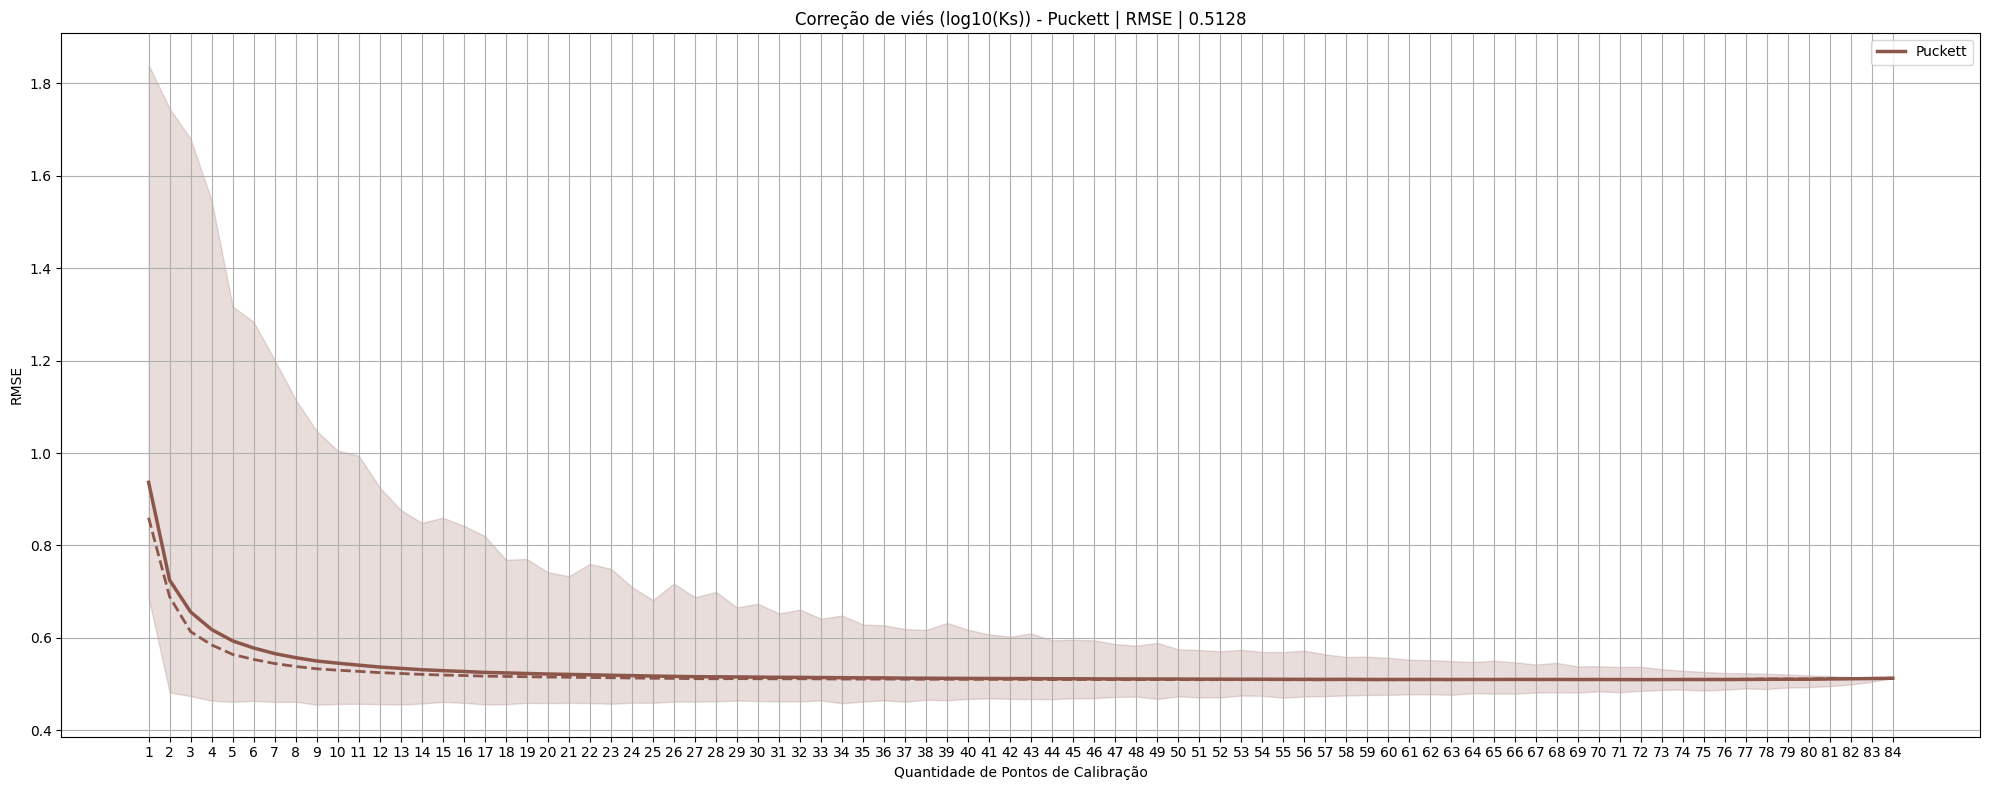

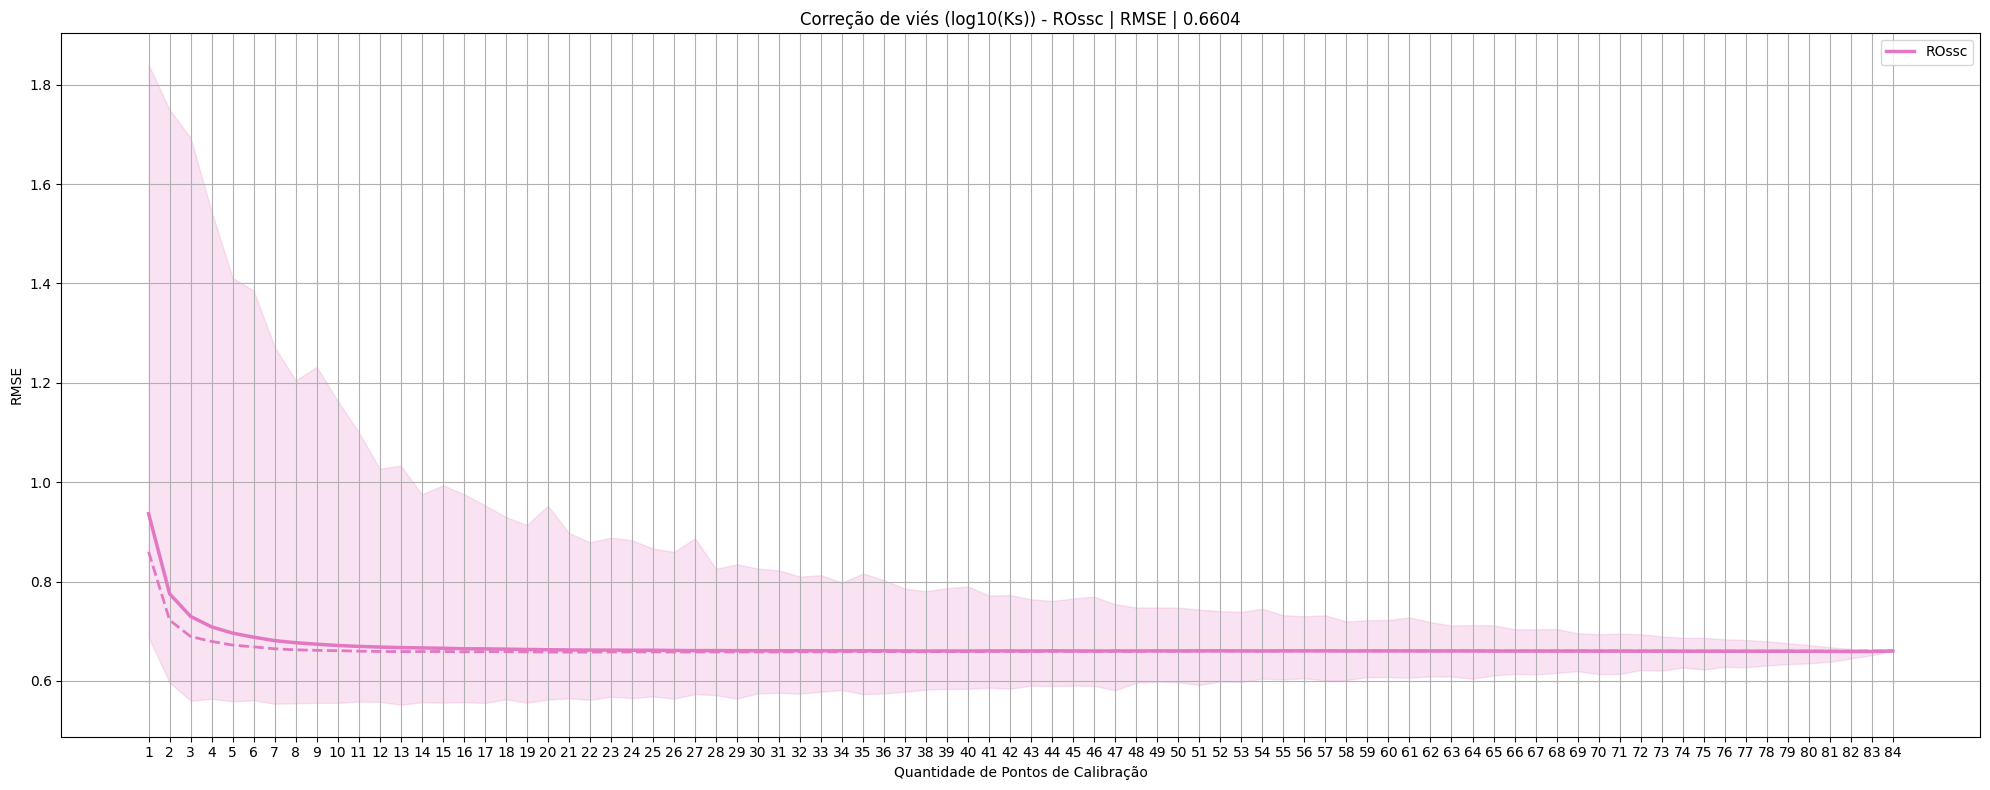

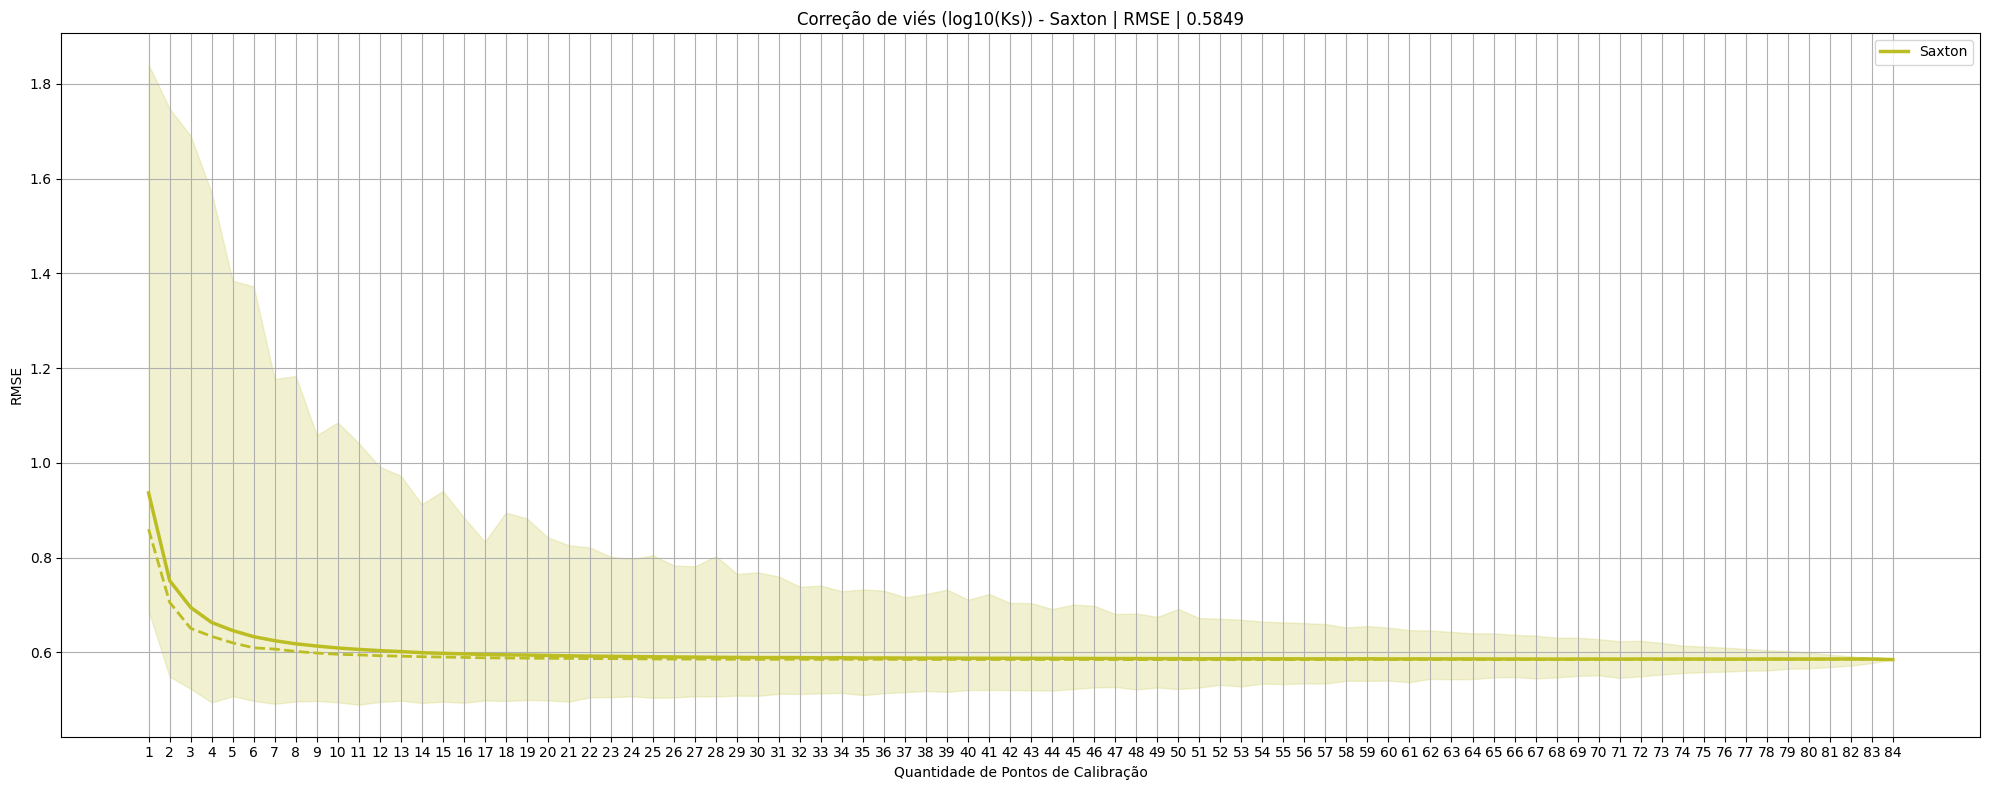

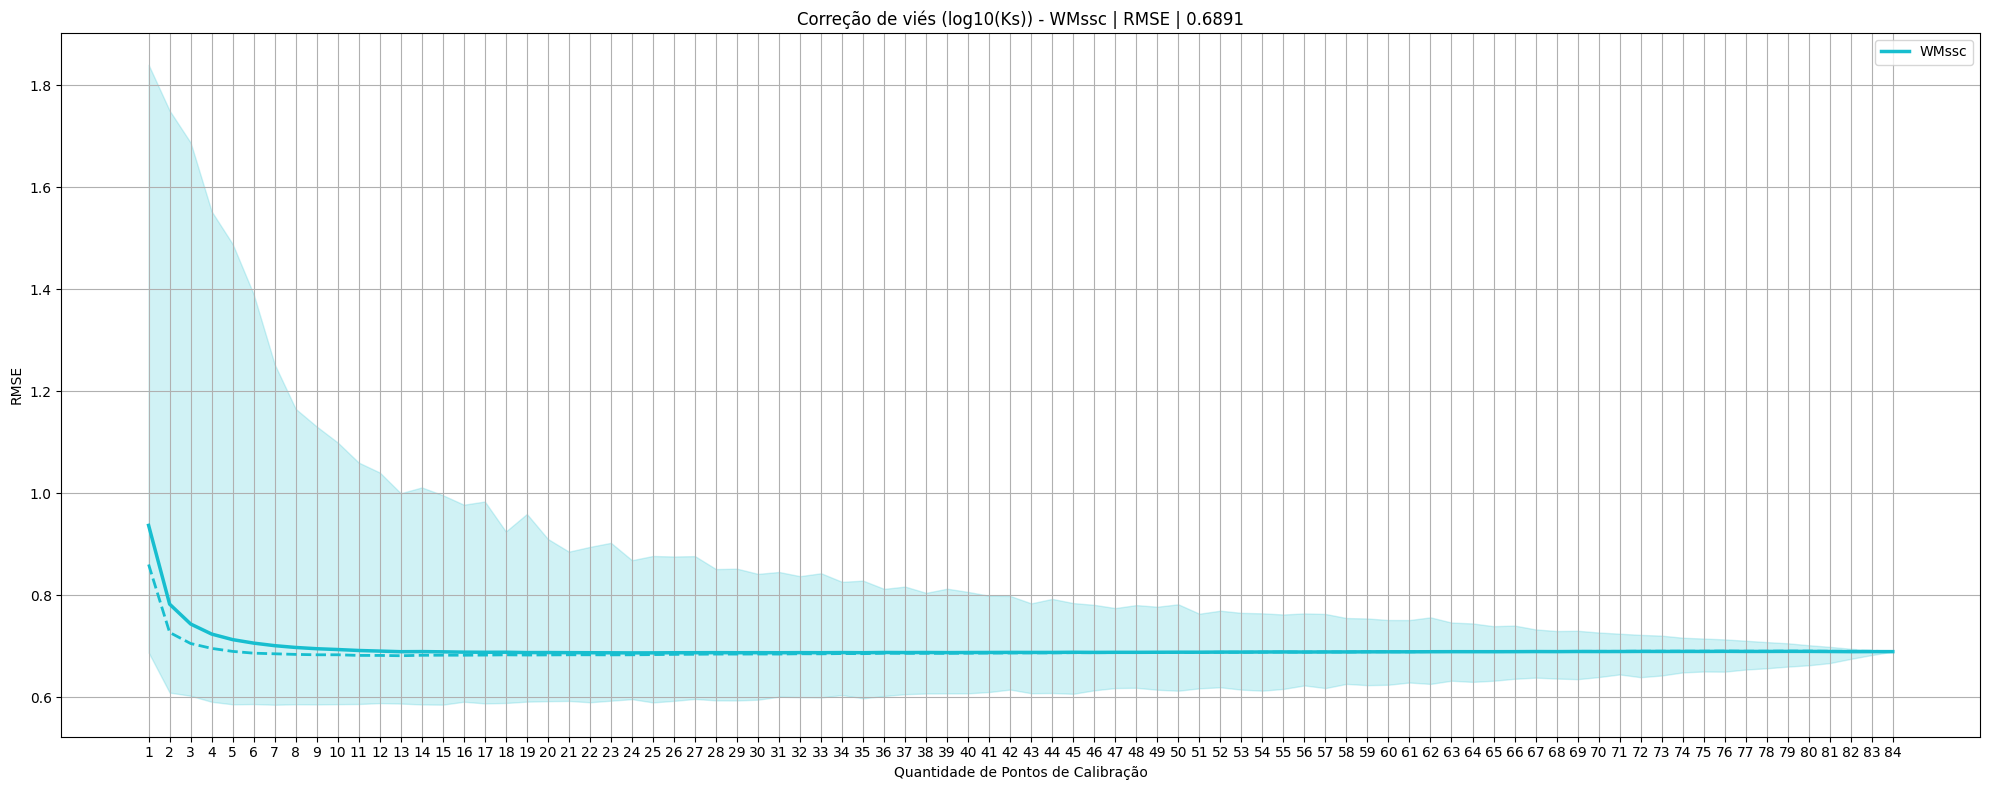

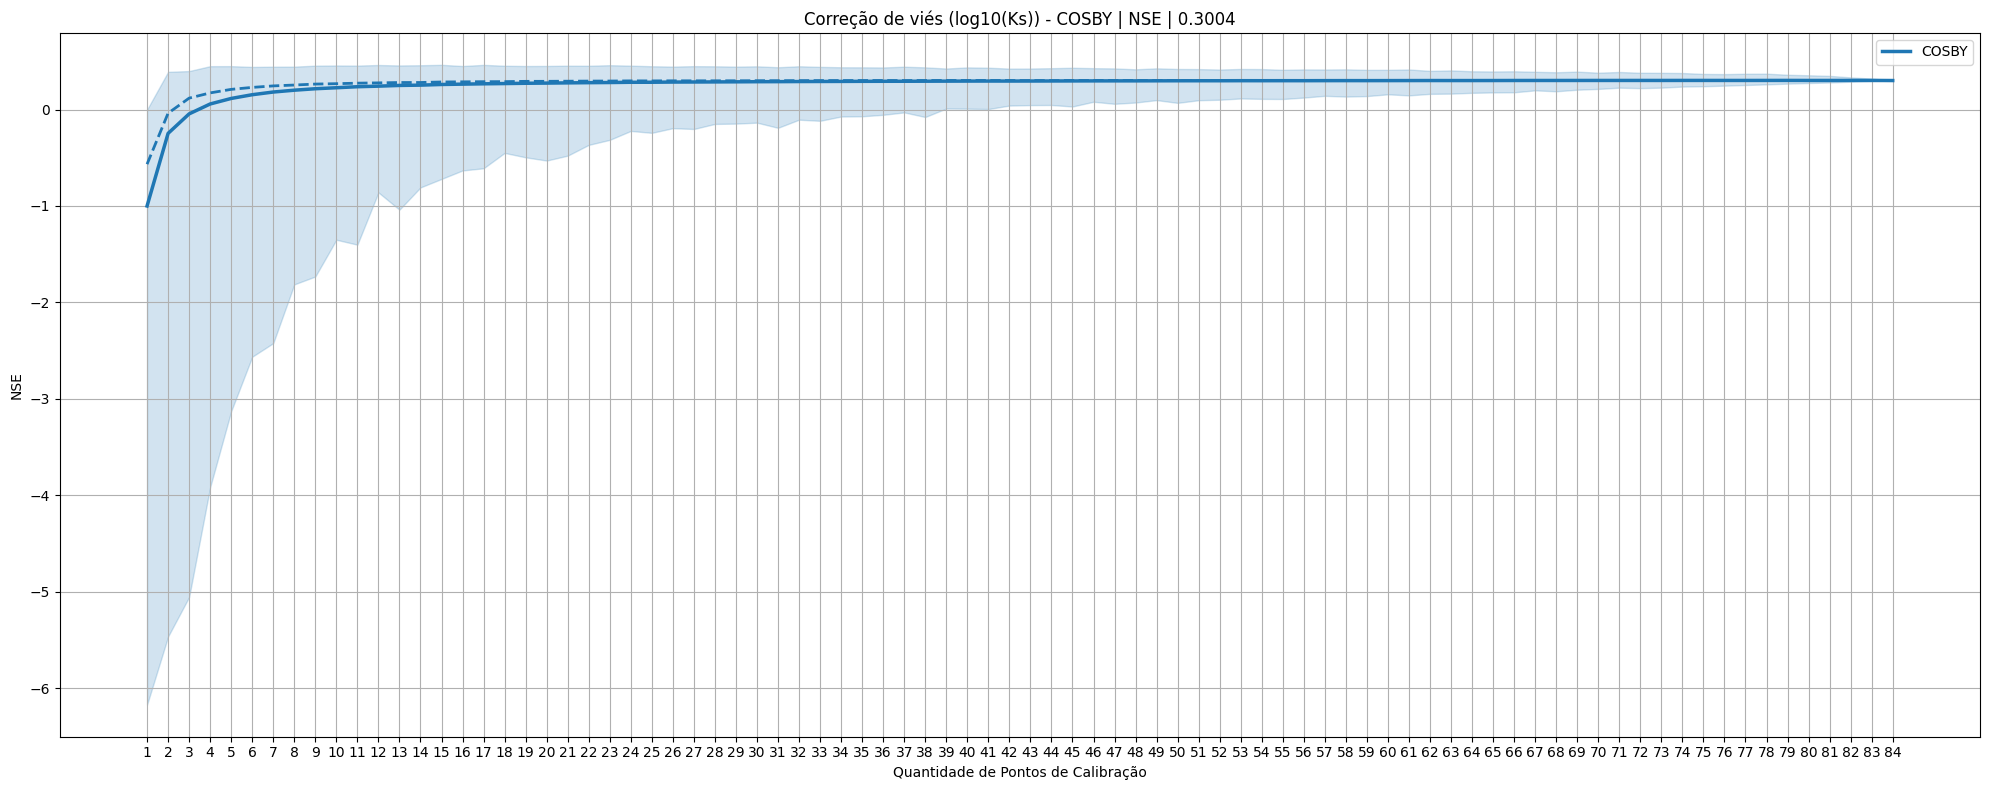

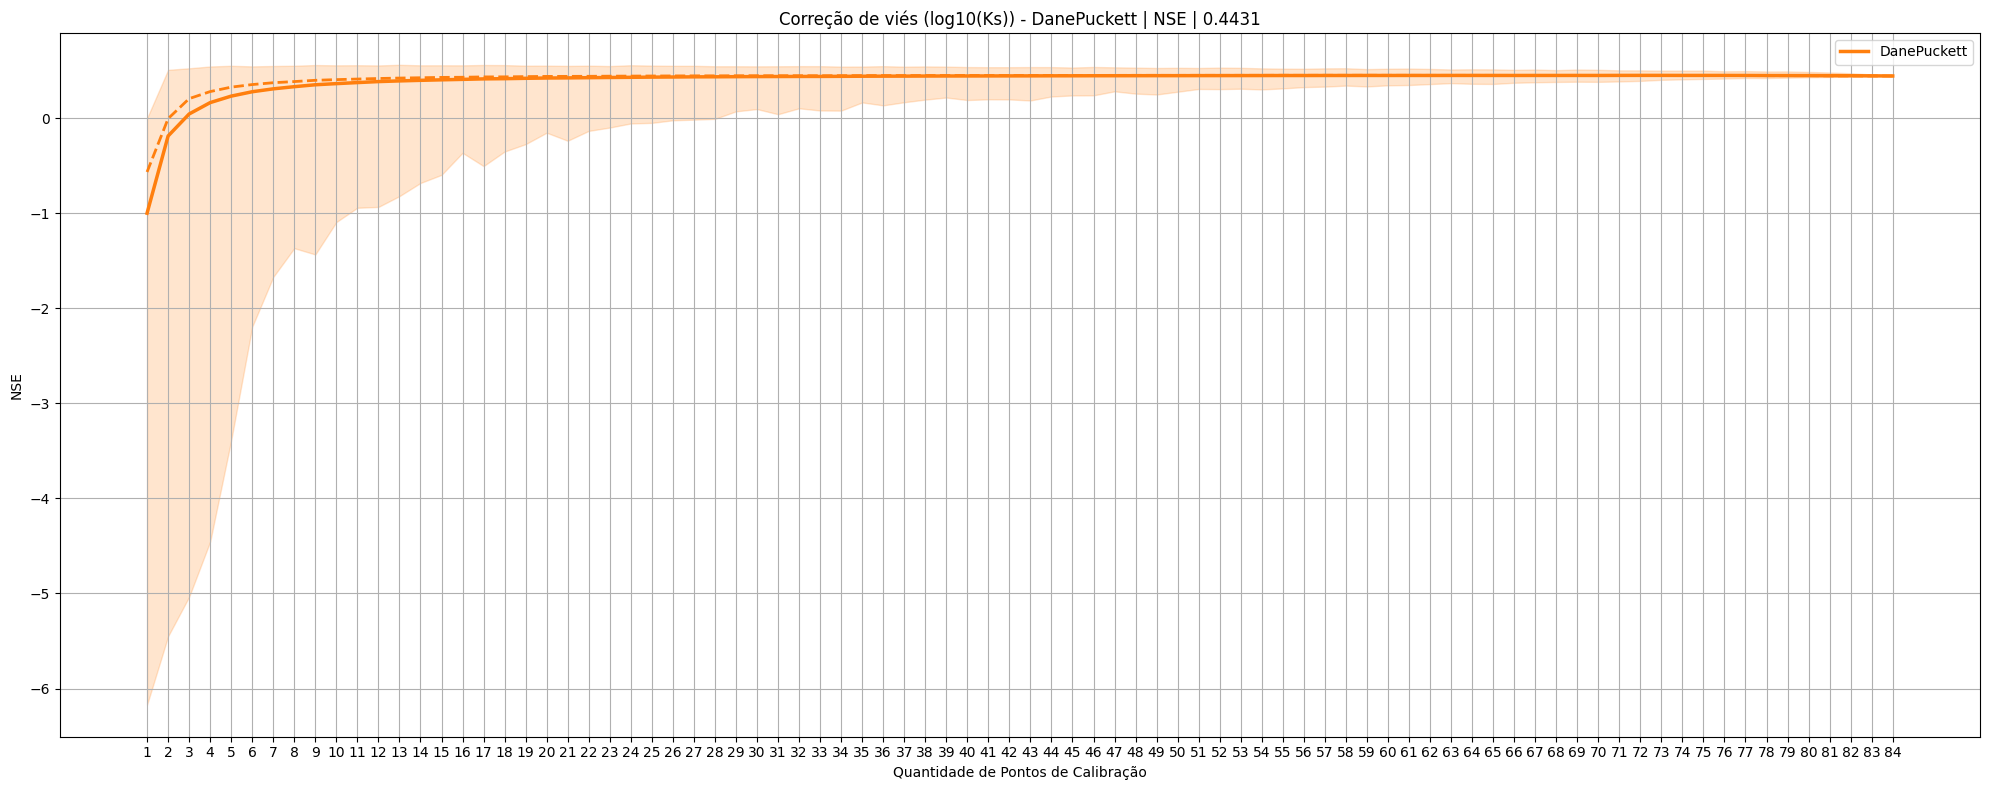

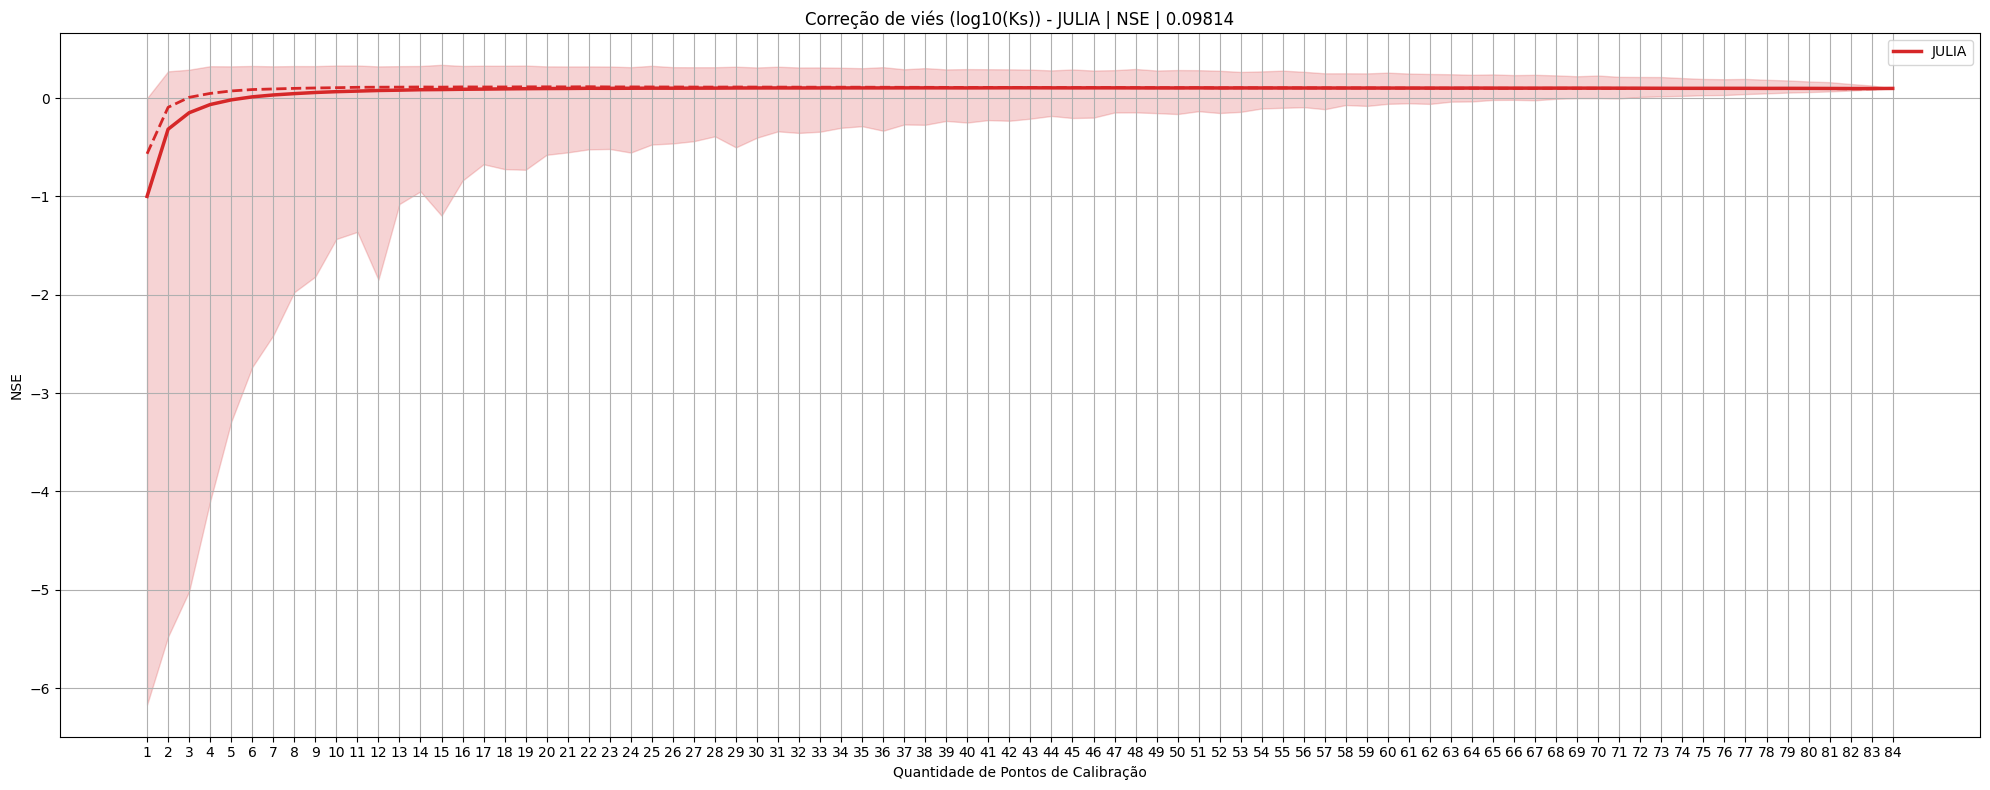

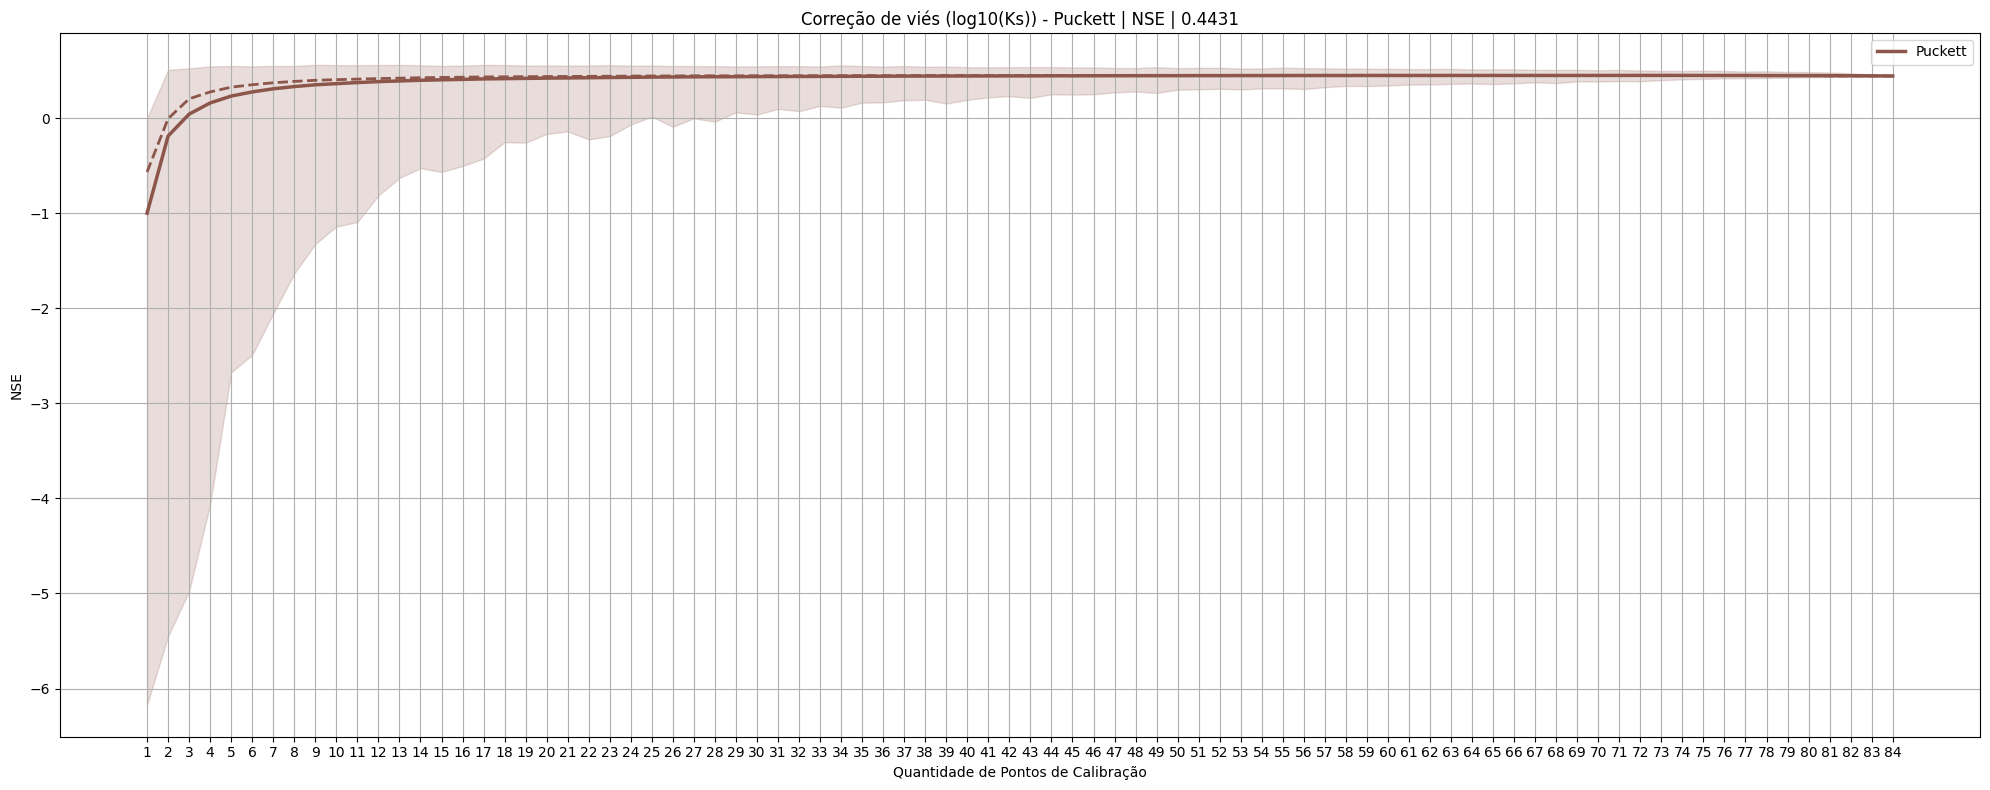

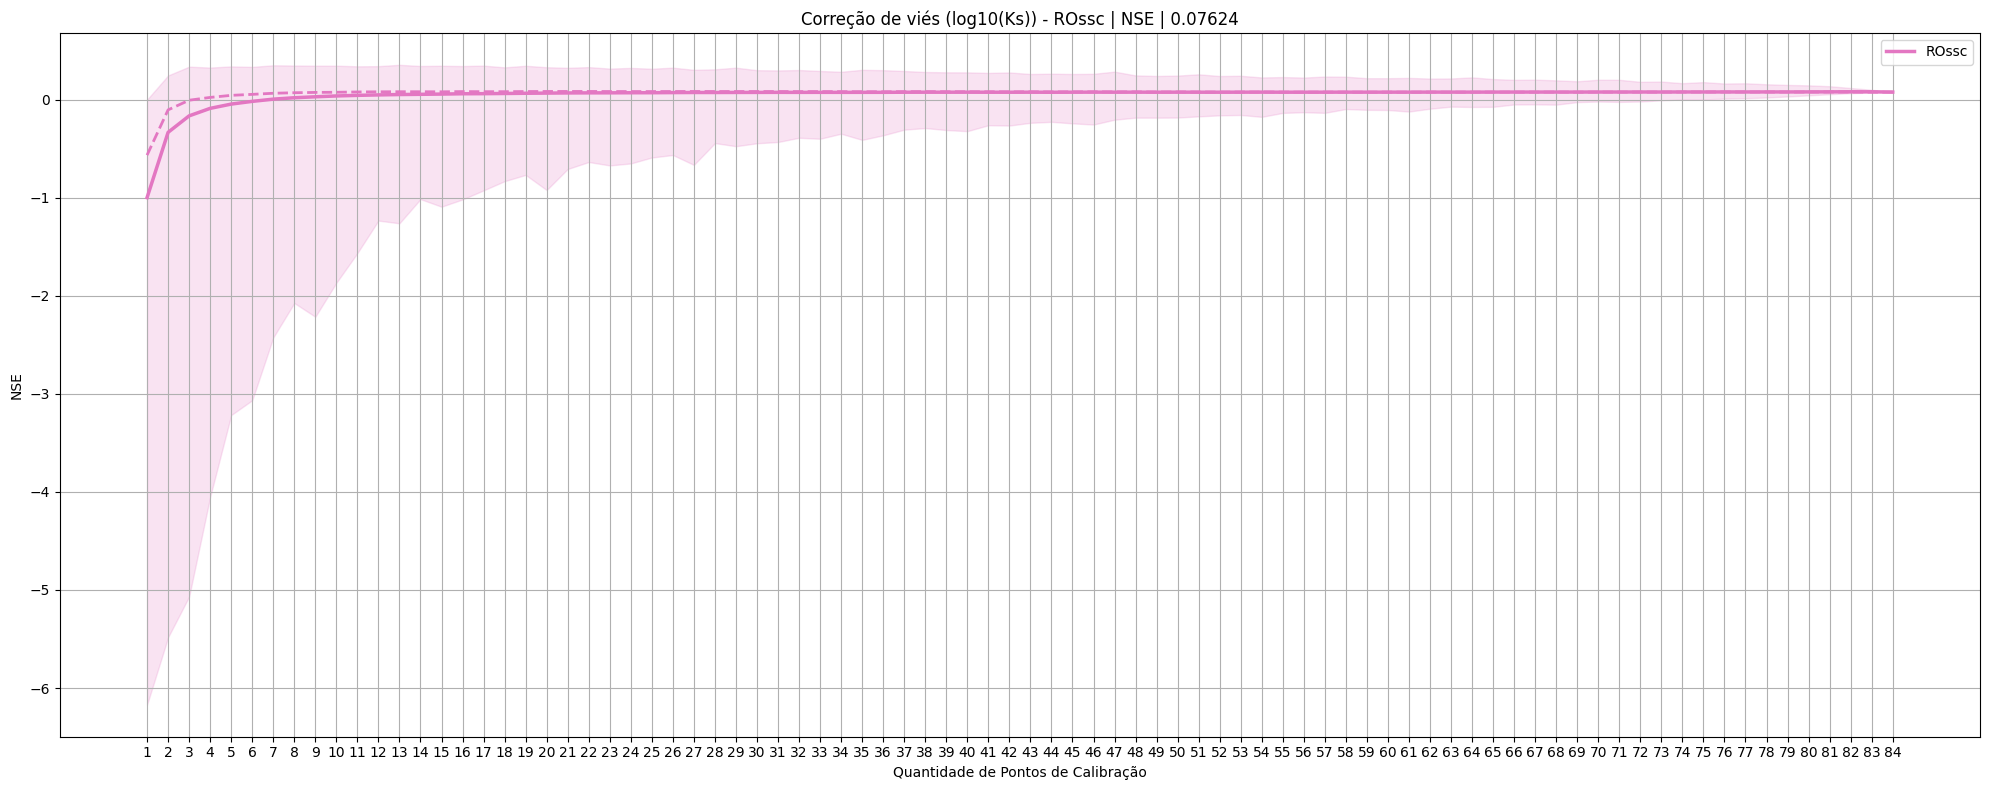

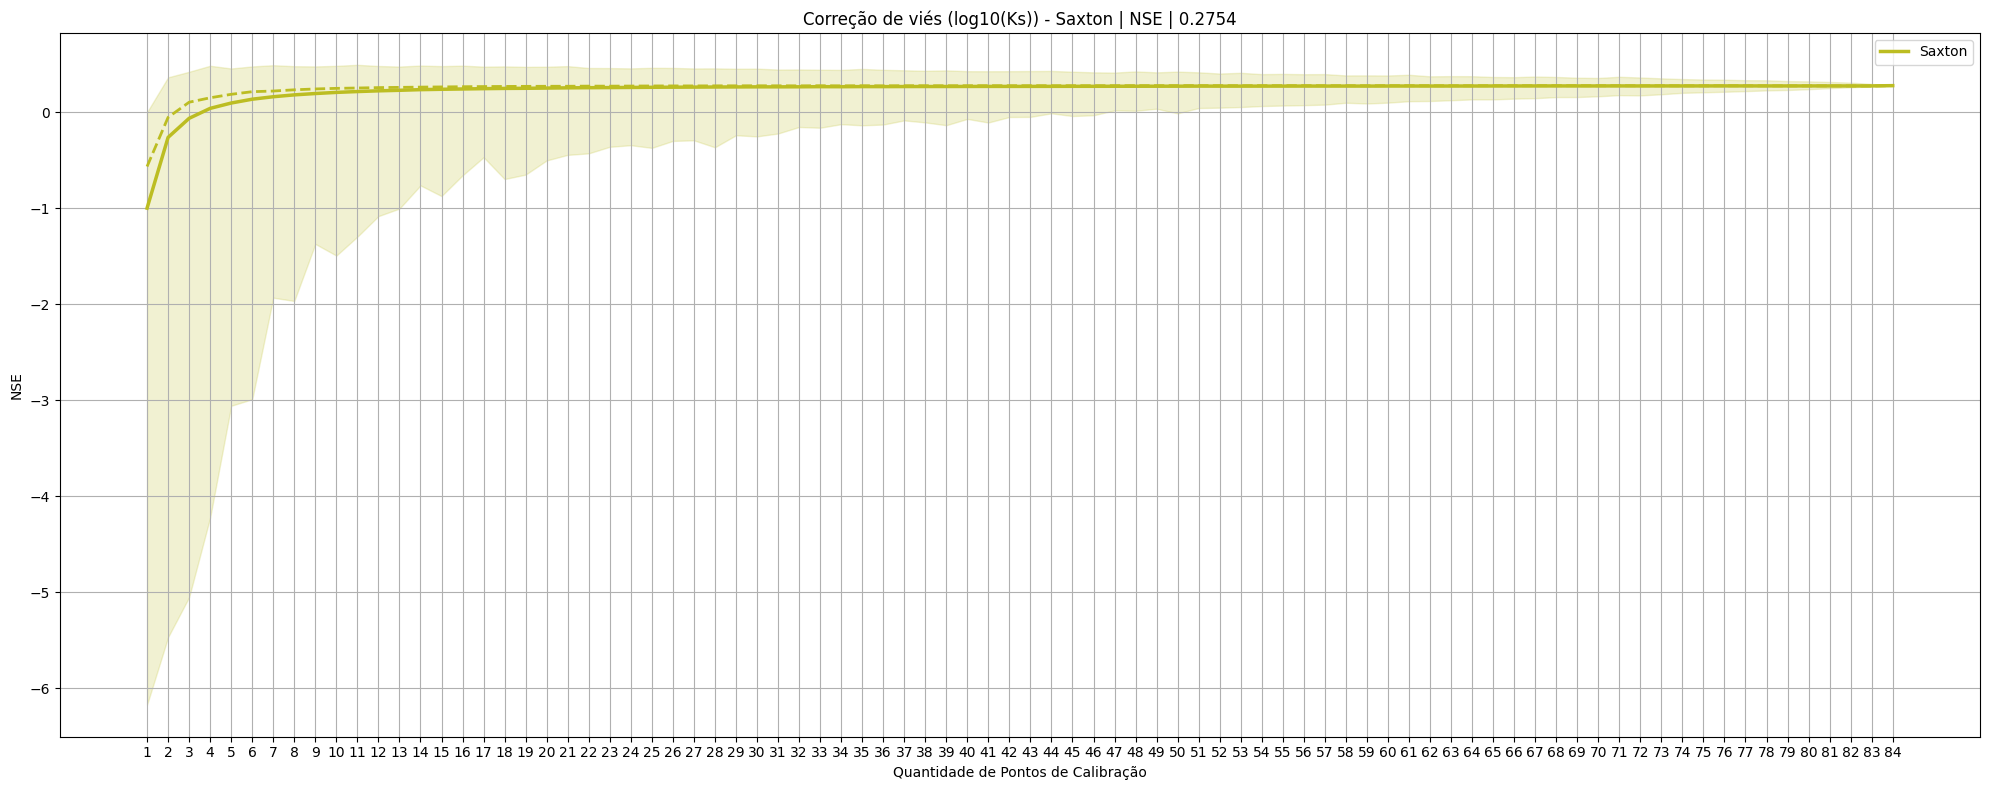

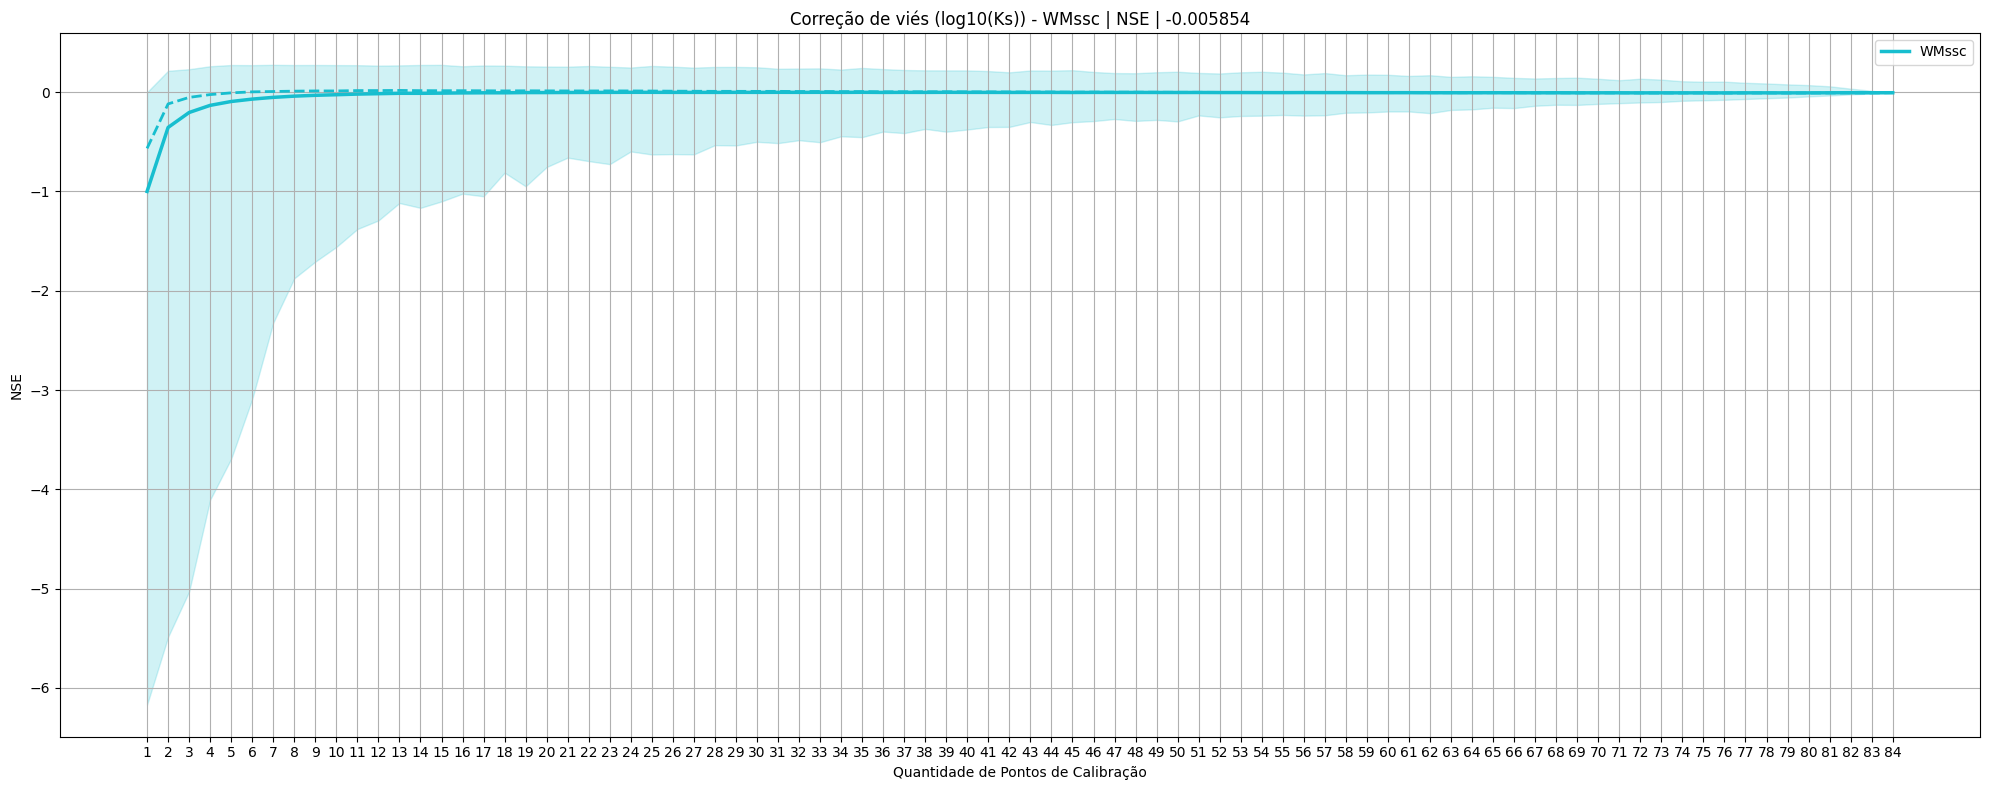

In [ ]:
# NSE ou RMSE por número de pontos de calibração
params = ["RMSE", "NSE"]

x = np.arange(1, 85)

types = os.listdir("simulacoes")
colors = plt.cm.tab10(np.linspace(0, 1, len(types)))

for param in params:

    for color, sim_type in zip(colors, types):
        minimos  = []
        maximos  = []
        medios   = []
        medianos = []

        for i in range(1, 85):
            df = pd.read_excel(f"simulacoes/{sim_type}/CV_{i}.xlsx", nrows=10)

            minimos.append(df[f"{param}_MIN"].values[0])
            maximos.append(df[f"{param}_MAX"].values[0])
            medios.append(df[f"{param}_MEAN"].values[0])
            medianos.append(df[f"{param}_MEDIAN"].values[0])

        plt.figure(figsize=(20, 8))

        # Área do mínimo ao máximo
        plt.fill_between(
            x, minimos, maximos,
            color=color,
            alpha=0.2,
        )

        # Linha média
        plt.plot(
            x, medios,
            color=color,
            linestyle="-",
            linewidth=2.5,
            label=sim_type
        )

        # Linha mediana
        plt.plot(
            x, medianos,
            color=color,
            linestyle="--",
            linewidth=2,
        )

        # Estética
        plt.xticks(np.arange(1, 85))
        plt.xlabel("Quantidade de Pontos de Calibração")
        plt.ylabel(param)
        plt.title(f"Correção de viés (log10(Ks)) - {sim_type} | {param} | {medios[-1]:.4g}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        # Salvar
        plt.savefig(f"graficos/CV_NPontos_{sim_type}_{param}.png", dpi=450)
        plt.show()